In [1]:
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import datetime

import pandas as pd
import numpy as np
import prefect
from prefect import task, Flow, Task

from fbsimulate import BaseTask, SimulatePipeline

from IPython.display import Image
import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

# 1. Inspired by scikit-learn Pipeline Design 

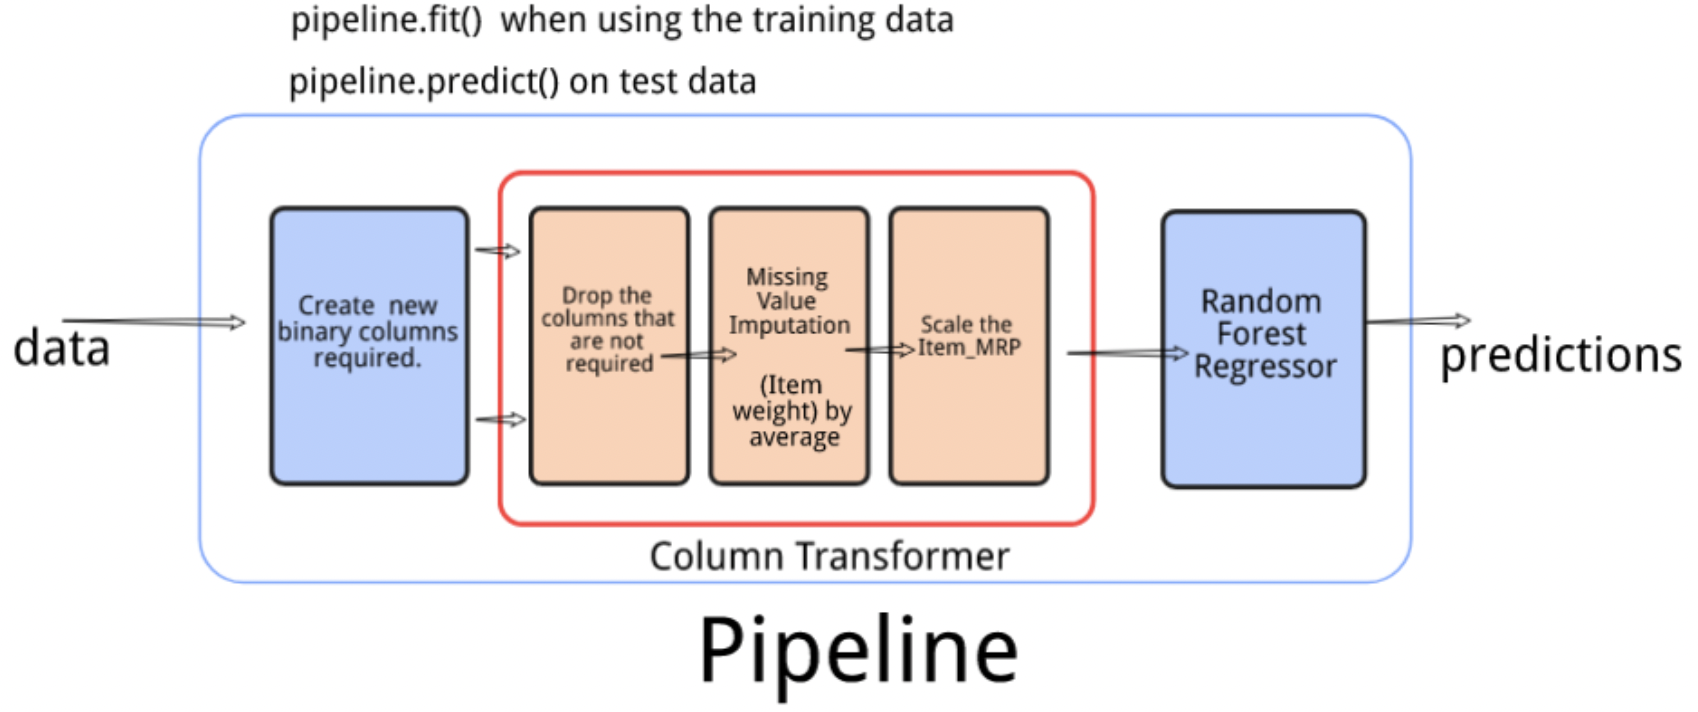

In [3]:
Image(filename='sklearn.png') 

# 2. Set Hyper Parameters to Run

In [4]:
number_customers = 10000
first_sessions_simu_period = (datetime.datetime(2015, 1, 1), datetime.datetime(2025, 1, 1))
# Parameters of the Negative Binomiale distributions from which
## the number of sessions is drawn for each customer
## the average days between sessions is drawn for each customer
NB_params_number_of_sessions = (4, 0.1)
NB_params_avg_days_between_sessions = (1.5, 0.1)

first_sessions_simu_period_ms = (
    int(round(first_sessions_simu_period[0].timestamp() * 1000)),
    int(round(first_sessions_simu_period[1].timestamp() * 1000))
)

# 3. Define Simulation Tasks

## 3.1 Define Task Classes

### 3.1.1 Load Data

In [5]:
class LoadBrowsingInfo(BaseTask):
    def __init__(self, file_path, name=None):
        self._file_path = file_path
        super().__init__(name=name)
    
    def execute(self):
        browsing = pd.read_csv(self._file_path)
        return browsing

### 3.1.2 Simulate Customer Information

In [6]:
class GenerateCustomerInfo(BaseTask):
    
    def execute(self, browsing_info):
        browsing_session_ids = browsing_info.session_id_hash.unique()
        browsing_session_first_timestamp = browsing_info.groupby('session_id_hash').server_timestamp_epoch_ms.agg('min')
        
        cust_simu = self._init_cust_info()
        cust_simu['session_timestamps'] = cust_simu.apply(self._session_timestamps, axis=1)
        cust_simu = self._post_process_custinfo(cust_simu, browsing_session_ids, browsing_session_first_timestamp)
        
        return cust_simu
    
    def _init_cust_info(self):
        cust_simu = pd.DataFrame({
            'cust_id': range(number_customers),
            'first_session': np.random.uniform(
                first_sessions_simu_period_ms[0],
                first_sessions_simu_period_ms[1],
                number_customers
            ).astype(int),
            'number_sessions': np.random.negative_binomial(
                NB_params_number_of_sessions[0],
                NB_params_number_of_sessions[1],
                number_customers
            ) + 1,
            'avg_days_between_sessions': np.random.negative_binomial(
                NB_params_number_of_sessions[0],
                NB_params_number_of_sessions[1],
                number_customers
            ) + 0.5
        })
        
        return cust_simu
        
    def _session_timestamps(self, X):
        first_session = int(X.first_session)
        number_sessions = int(X.number_sessions)
        avg_days_between_sessions = X.avg_days_between_sessions

        sessions = [first_session]
        if number_sessions == 1:
            return sessions
        
        time_between_sessions = np.random.exponential(
            avg_days_between_sessions, number_sessions - 1) * 24 * 60 * 60 * 1000
        
        for i in range(number_sessions - 1):
            sessions.append(sessions[i] + int(time_between_sessions[i]))
            
        return sessions
    
    def _post_process_custinfo(self, cust_simu, browsing_session_ids, browsing_session_first_timestamp):
        cust_simu.drop(columns=['first_session', 'number_sessions', 'avg_days_between_sessions'], inplace=True)
        cust_simu = cust_simu.explode('session_timestamps')
        cust_simu['session_timestamps'] = cust_simu['session_timestamps'].astype(int)
        cust_simu['session_id_hash'] = np.random.choice(browsing_session_ids, len(cust_simu))
        cust_simu['timestamp_adjustment'] = cust_simu['session_timestamps'] - browsing_session_first_timestamp[cust_simu['session_id_hash']].values
        
        return cust_simu


### 3.1.3 Merge & Create Final Simulated Data

In [7]:
class CreateSimulateBrowsingInfo(BaseTask):
    
    def execute(self, cust_simu, browsing_info):
        cust_simu = pd.merge(cust_simu, browsing_info, how='left', on='session_id_hash')
        cust_simu['server_timestamp_epoch_ms'] += cust_simu['timestamp_adjustment']
        cust_simu.drop(columns=['session_timestamps', 'timestamp_adjustment'], inplace=True)
        cust_simu = cust_simu[cust_simu.server_timestamp_epoch_ms < first_sessions_simu_period_ms[1]]
        
        return cust_simu

### 3.1.4 Write to Snowflake and Databricks

In [8]:
class WriteToDatabricks(BaseTask):
    def execute(self, simulate_info): 
        pass

class WriteToSnowflake(BaseTask):
    def execute(self, simulate_info): 
        pass

## 3.2 Define Dependency between Tasks

In [9]:
pipeline = SimulatePipeline('Browsing Data Simulation Run')

load_task = LoadBrowsingInfo(file_path="../train/browsing_train.csv")
pipeline.register(load_task)

gen_custinfo_task = GenerateCustomerInfo()
pipeline.register(gen_custinfo_task, depends_on=[load_task])

create_simu_info_task = CreateSimulateBrowsingInfo()
pipeline.register(create_simu_info_task, depends_on=[gen_custinfo_task, load_task])

write_databricks = WriteToDatabricks()
pipeline.register(write_databricks, depends_on=[create_simu_info_task])

write_snowflake = WriteToSnowflake()
pipeline.register(write_snowflake, depends_on=[create_simu_info_task])

## 3.3 Visualize the Simulation Pipeline

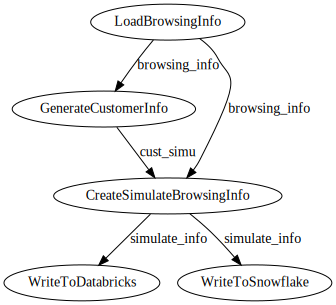

In [10]:
pipeline.visualize()

## 3.4 Execute the Pipeline

In [11]:
pipeline.execute()

[2022-03-28 14:56:11+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'Browsing Data Simulation Run'
[2022-03-28 14:56:11+0800] INFO - prefect.TaskRunner | Task 'LoadBrowsingInfo': Starting task run...
[2022-03-28 14:56:56+0800] INFO - prefect.LoadBrowsingInfo | LoadBrowsingInfo takes 44.95496106147766 seconds
[2022-03-28 14:56:56+0800] INFO - prefect.TaskRunner | Task 'LoadBrowsingInfo': Finished task run for task with final state: 'Success'
[2022-03-28 14:56:56+0800] INFO - prefect.TaskRunner | Task 'GenerateCustomerInfo': Starting task run...
[2022-03-28 14:57:24+0800] INFO - prefect.GenerateCustomerInfo | GenerateCustomerInfo takes 27.972944259643555 seconds
[2022-03-28 14:57:24+0800] INFO - prefect.TaskRunner | Task 'GenerateCustomerInfo': Finished task run for task with final state: 'Success'
[2022-03-28 14:57:24+0800] INFO - prefect.TaskRunner | Task 'CreateSimulateBrowsingInfo': Starting task run...
[2022-03-28 14:57:35+0800] INFO - prefect.CreateSimulateBrowsingInfo | 

## 3.5 Get Pipeline Output from the Simulate Step or Any Other Step

In [13]:
df1 = pipeline.get_output(create_simu_info_task)
df1

,cust_id,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,0,d0e24d126eb8ea5dcd23d24a9664ea0c1b16a603bccc7d...,pageview,NaN,NaN,1470103171258,d8f0f372d4cada27a98f18d89d75dad825d7dad8382d22...
1,0,d0e24d126eb8ea5dcd23d24a9664ea0c1b16a603bccc7d...,event_product,detail,e02d4c96fecc7d1e23d046972b721b53e8701e5730ea46...,1470103171258,d8f0f372d4cada27a98f18d89d75dad825d7dad8382d22...
2,0,99f167fa28c4b902c792a25e7bc5a35089280ccd5d733a...,pageview,NaN,NaN,1470922115808,cb037290ef09d7db435b5f2de346e349f01f4c2e8aeb24...
3,0,8fa88c979eed448963ec474a2e0a82e666aa3193f831f1...,pageview,NaN,NaN,1476595056278,433b0e71df1fe9a8d1f45647545701f6108414c40eef76...
4,0,8fa88c979eed448963ec474a2e0a82e666aa3193f831f1...,pageview,NaN,NaN,1476595068133,58d2d57037f2a28b6562166920189a5f6c40907e8e7b77...
...,...,...,...,...,...,...,...
2732751,9998,61eeb729dad7dad78275d8af74bf7aa81fdc2f58b7daea...,pageview,NaN,NaN,1729043622224,2eae2fa59018defe608e89f86ba0d674053f0d516e3938...
2732752,9998,61eeb729dad7dad78275d8af74bf7aa81fdc2f58b7daea...,event_product,detail,5792cf576bb4e4c643deda5ac07f0d2de7f712e56f4695...,1729043622224,2eae2fa59018defe608e89f86ba0d674053f0d516e3938...
2732753,9998,61eeb729dad7dad78275d8af74bf7aa81fdc2f58b7daea...,pageview,NaN,NaN,1729043641563,82382129c1c56ea142b088111607234e0046ae3be18afa...
2732754,9998,8be4686c2f53815f78327c9fb9340238243546c596a01d...,pageview,NaN,NaN,1730690794012,c5345319c663aa93d6ad6e57fded8e7df9a1473bffb043...


In [14]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2133330 entries, 0 to 2732897
Data columns (total 7 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   cust_id                    int64 
 1   session_id_hash            object
 2   event_type                 object
 3   product_action             object
 4   product_sku_hash           object
 5   server_timestamp_epoch_ms  int64 
 6   hashed_url                 object
dtypes: int64(2), object(5)
memory usage: 130.2+ MB


## 3.6 Execute the Pipeline Every 60 Seconds

In [16]:
pipeline.execute(frequency=60)

## 3.7 Execute the Pipeline at the 15th Minute of Every Hour

In [15]:
pipeline.execute(cron='15 * * * *')

# 4. Deconstruct Further into More Modular Tasks

## 4.1 Deconstruct Customer Simulation into More Steps

In [16]:
class CreateBrowsingStats(BaseTask):
    
    def execute(self, browsing_info):
        browsing_session_ids = browsing_info.session_id_hash.unique()
        browsing_session_first_timestamp = browsing_info.groupby('session_id_hash').server_timestamp_epoch_ms.agg('min')
        
        return browsing_session_ids, browsing_session_first_timestamp
    

class InitCustInfo(BaseTask):
    
    def execute(self):
        cust_info = pd.DataFrame({
            'cust_id': range(number_customers),
            'first_session': np.random.uniform(
                first_sessions_simu_period_ms[0],
                first_sessions_simu_period_ms[1],
                number_customers
            ).astype(int),
            'number_sessions': np.random.negative_binomial(
                NB_params_number_of_sessions[0],
                NB_params_number_of_sessions[1],
                number_customers
            ) + 1,
            'avg_days_between_sessions': np.random.negative_binomial(
                NB_params_number_of_sessions[0],
                NB_params_number_of_sessions[1],
                number_customers
            ) + 0.5
        })
        
        return cust_info
    
class ApplyCustInfoTimestamp(BaseTask):
    
    def execute(self, cust_info):
        cust_info['session_timestamps'] = cust_info.apply(self._session_timestamps, axis=1)
        return cust_info
    
    def _session_timestamps(self, X):
        first_session = int(X.first_session)
        number_sessions = int(X.number_sessions)
        avg_days_between_sessions = X.avg_days_between_sessions

        sessions = [first_session]
        if number_sessions == 1:
            return sessions
        
        time_between_sessions = np.random.exponential(
            avg_days_between_sessions, number_sessions - 1) * 24 * 60 * 60 * 1000
        
        for i in range(number_sessions - 1):
            sessions.append(sessions[i] + int(time_between_sessions[i]))
            
        return sessions
    
class PostProcessCustInfo(BaseTask):
    
    def execute(self, cust_info, browsing_stats):
        browsing_session_ids, browsing_session_first_timestamp = browsing_stats[0], browsing_stats[1]
        
        cust_info.drop(columns=['first_session', 'number_sessions', 'avg_days_between_sessions'], inplace=True)
        cust_info = cust_info.explode('session_timestamps')
        cust_info['session_timestamps'] = cust_info['session_timestamps'].astype(int)
        cust_info['session_id_hash'] = np.random.choice(browsing_session_ids, len(cust_info))
        cust_info['timestamp_adjustment'] = cust_info['session_timestamps'] - browsing_session_first_timestamp[cust_info['session_id_hash']].values
        
        return cust_info


## 4.2 Define Dependency between Task Classes

In [17]:
pipeline = SimulatePipeline('Browsing Data Simulation Run 2')

load_task = LoadBrowsingInfo(file_path="../train/browsing_train.csv")
pipeline.register(load_task)

browsing_stats_task = CreateBrowsingStats()
pipeline.register(browsing_stats_task, depends_on=[load_task])

init_custinfo_task = InitCustInfo()
pipeline.register(init_custinfo_task)

apply_custinfo_ts_task = ApplyCustInfoTimestamp()
pipeline.register(apply_custinfo_ts_task, depends_on=[init_custinfo_task])

postprocess_custinfo_task = PostProcessCustInfo()
pipeline.register(postprocess_custinfo_task, depends_on=[apply_custinfo_ts_task, browsing_stats_task])

create_simu_info_task = CreateSimulateBrowsingInfo()
pipeline.register(create_simu_info_task, depends_on=[postprocess_custinfo_task, load_task])

write_databricks = WriteToDatabricks()
pipeline.register(write_databricks, depends_on=[create_simu_info_task])

write_snowflake = WriteToSnowflake()
pipeline.register(write_snowflake, depends_on=[create_simu_info_task])


## 4.3 Visualize the New Simulation Pipeline

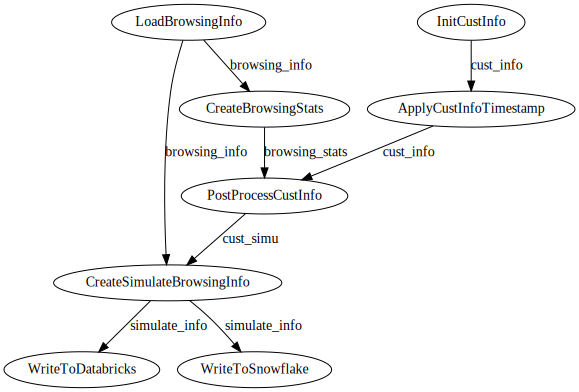

In [18]:
pipeline.visualize()

## 4.4 Execute the Pipeline and Get Result

In [19]:
pipeline.execute()

[2022-03-28 14:40:03+0800] INFO - prefect.FlowRunner | Beginning Flow run for 'Browsing Data Simulation Run 2'
[2022-03-28 14:40:03+0800] INFO - prefect.TaskRunner | Task 'LoadBrowsingInfo': Starting task run...
[2022-03-28 14:40:43+0800] INFO - prefect.LoadBrowsingInfo | LoadBrowsingInfo takes 40.662795066833496 seconds
[2022-03-28 14:40:43+0800] INFO - prefect.TaskRunner | Task 'LoadBrowsingInfo': Finished task run for task with final state: 'Success'
[2022-03-28 14:40:43+0800] INFO - prefect.TaskRunner | Task 'CreateBrowsingStats': Starting task run...
[2022-03-28 14:41:07+0800] INFO - prefect.CreateBrowsingStats | CreateBrowsingStats takes 23.332597017288208 seconds
[2022-03-28 14:41:07+0800] INFO - prefect.TaskRunner | Task 'CreateBrowsingStats': Finished task run for task with final state: 'Success'
[2022-03-28 14:41:07+0800] INFO - prefect.TaskRunner | Task 'InitCustInfo': Starting task run...
[2022-03-28 14:41:07+0800] INFO - prefect.InitCustInfo | InitCustInfo takes 0.00356817

In [20]:
df2 = pipeline.get_output(create_simu_info_task)
df2

,cust_id,session_id_hash,event_type,product_action,product_sku_hash,server_timestamp_epoch_ms,hashed_url
0,0,e4747c9f7b8324abcbd8c48112518a6fd0a7cefdedb0fe...,pageview,NaN,NaN,1421267020342,b5b8476156996965e11bf48669bd90cca078e2825fcdae...
1,0,d2d33020caa2bafd4984685adecfd0a32e0280f6ee15b9...,event_product,detail,e5d7506b30152c8452377d53f7fa02a9afae8d9bcb57ae...,1424050214069,73c2d82eb8e6d570b86492aec00917dffa621f394ec970...
2,0,d2d33020caa2bafd4984685adecfd0a32e0280f6ee15b9...,pageview,NaN,NaN,1424050214069,73c2d82eb8e6d570b86492aec00917dffa621f394ec970...
3,0,b3d0f0bd130ba6310cd13ab942fbf40c13a5b58febad76...,event_product,detail,312882833ec43db8aacc896311529f81bf962227029a23...,1424484113580,94d7d41e2968c725b5c7e17b3e290e63d0002d0d91a4d4...
4,0,b3d0f0bd130ba6310cd13ab942fbf40c13a5b58febad76...,pageview,NaN,NaN,1424484113580,94d7d41e2968c725b5c7e17b3e290e63d0002d0d91a4d4...
...,...,...,...,...,...,...,...
2693119,9999,314eb3b950ac50d8b3e792cf91bbff82bc2bdee6eb18d5...,event_product,detail,2817442282a6e3854c5e171c1d63b0526e436a8de169e4...,1612396906657,c69caed201793ebd8d347bc393cdf9f929e063bee5d948...
2693120,9999,314eb3b950ac50d8b3e792cf91bbff82bc2bdee6eb18d5...,pageview,NaN,NaN,1612396933259,dfb03d8dea4111f461b0f96bf7dfd54b72bd193bdcd4ef...
2693121,9999,314eb3b950ac50d8b3e792cf91bbff82bc2bdee6eb18d5...,event_product,detail,1f7e98b84ca23daeb9d217e57ba7b96e31f835b546e692...,1612396933259,dfb03d8dea4111f461b0f96bf7dfd54b72bd193bdcd4ef...
2693122,9999,314eb3b950ac50d8b3e792cf91bbff82bc2bdee6eb18d5...,pageview,NaN,NaN,1612396949934,c69caed201793ebd8d347bc393cdf9f929e063bee5d948...


In [21]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2075815 entries, 0 to 2693123
Data columns (total 7 columns):
 #   Column                     Dtype 
---  ------                     ----- 
 0   cust_id                    int64 
 1   session_id_hash            object
 2   event_type                 object
 3   product_action             object
 4   product_sku_hash           object
 5   server_timestamp_epoch_ms  int64 
 6   hashed_url                 object
dtypes: int64(2), object(5)
memory usage: 126.7+ MB
